In [1]:
import numpy as np
import cv2 #opencv
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('./trainingData/A/1.jpg')
img.shape

(512, 512, 3)

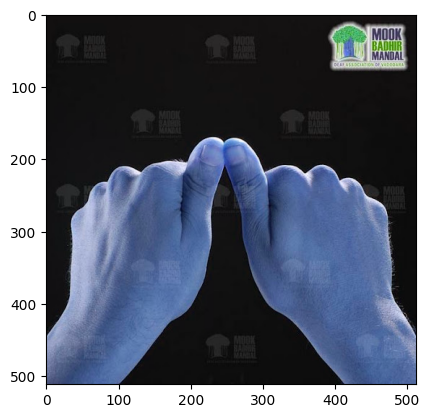

In [3]:
plt.imshow(img)

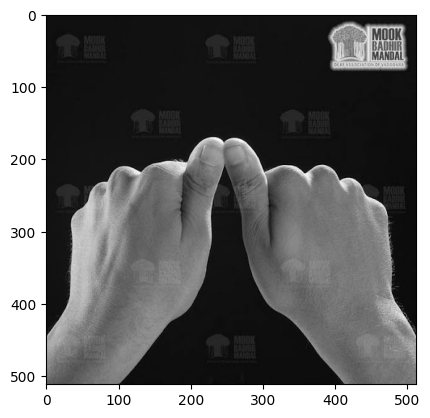

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape
plt.imshow(gray, cmap='gray')

## Remove Background

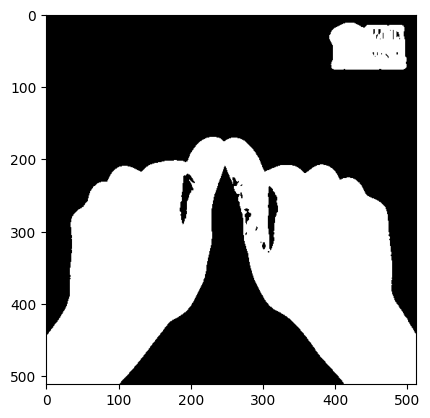

In [5]:
def bgremove1(myimage):
 
    # Blur to image to reduce noise
    myimage = cv2.GaussianBlur(myimage,(5,5), 0)
 
    # We bin the pixels. Result will be a value 1..5
    bins=np.array([0,51,102,153,204,255])
    myimage[:,:,:] = np.digitize(myimage[:,:,:],bins,right=True)*51
 
    # Create single channel greyscale for thresholding
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    # Perform Otsu thresholding and extract the background.
    # We use Binary Threshold as we want to create an all white background
    ret,background = cv2.threshold(myimage_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Perform Otsu thresholding and extract the foreground.
    # We use TOZERO_INV as we want to keep some details of the foregorund
    ret,foreground = cv2.threshold(myimage_grey,0,255,cv2.THRESH_TOZERO_INV+cv2.THRESH_OTSU)  #Currently foreground is only a mask
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Combine the background and foreground to obtain our final image
    finalimage = background
    return finalimage
    
img2= bgremove1(img)
plt.imshow(img2)

In [6]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

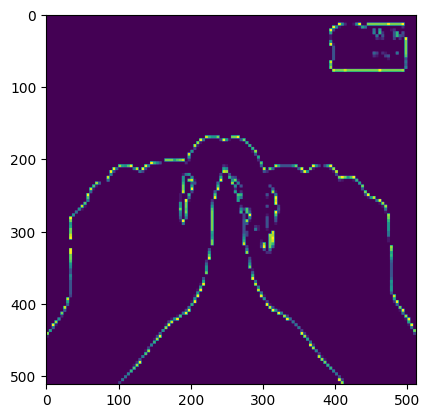

In [7]:
img_wvTrans = w2d(img2,'db1',2)
plt.imshow(img_wvTrans)

## Creating Dictionary To Iterate Over Folders

In [8]:
pathToFinalImgs = "./finalImages/"

In [9]:
import os
img_dirs = []
for entry in os.scandir(pathToFinalImgs):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [10]:
img_dirs

['./finalImages/A', './finalImages/B']

In [11]:
img_names_dict = {}
for img_dir in img_dirs:
    img_name = img_dir.split('/')[-1]
    img_list = []
    for entry in os.scandir(img_dir):
        img_list.append(entry.path)
    img_names_dict[img_name] = img_list
img_names_dict

{'A': ['./finalImages/A\\1.jpg',
  './finalImages/A\\2.jpg',
  './finalImages/A\\3.jpg',
  './finalImages/A\\4.jpg'],
 'B': ['./finalImages/B\\1.jpg',
  './finalImages/B\\2.jpg',
  './finalImages/B\\3.jpg',
  './finalImages/B\\BTest (1).jpg',
  './finalImages/B\\BTest.jpg',
  './finalImages/B\\bTest3.jpg']}

In [12]:
#giving nos. to each letter/no.

class_dict = {}
count = 0
for letter_class in img_names_dict.keys():
    class_dict[letter_class] = count
    count = count + 1
class_dict

{'A': 0, 'B': 1}

## Stacking different form of img, and creating X&Y

D:\Projects 2\picTrainedModel\modelVenv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


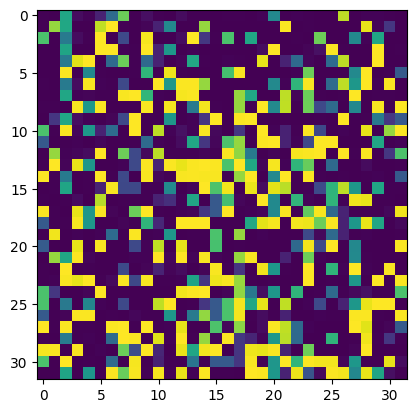

In [13]:
X, y = [], []
for letter_class, training_files in img_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        
        img_har = w2d(img,'db10',2)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        plt.imshow(scalled_img_har)
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[letter_class])     

##### len(X[0])

In [14]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(10, 4096)

## Time to train our model

In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas as pd

In [16]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
# pipe.fit(X_train, y_train)
# pipe.score(X_test, y_test)

pipe = make_pipeline(StandardScaler(), svm.SVC(gamma='auto',probability=False))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6666666666666666

In [17]:
print(classification_report(y_test, pipe.predict(X_test),zero_division=np.nan))

              precision    recall  f1-score   support

           0        nan      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.67      0.50      0.40         3
weighted avg       0.67      0.67      0.53         3



## Save Model & Class Dictionary

In [18]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(pipe, 'saved_model.pkl') 

['saved_model.pkl']

In [19]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))